In [1]:
import time
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM

In [2]:
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

In [3]:
df = pd.read_csv('000002-from-1995-01-01.csv')
df.head()

,open,high,low,volume,amount,close
0,20.64,20.64,20.37,16362363.0,3.350027e+08,20.56
1,20.92,20.92,20.60,21850597.0,4.520071e+08,20.64
2,21.00,21.15,20.72,26910139.0,5.628396e+08,20.94
3,20.70,21.57,20.70,64585536.0,1.363421e+09,21.02
4,20.60,20.70,20.20,45886018.0,9.382043e+08,20.70


In [4]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

In [5]:
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.values
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [6]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        units=layers[1],
        return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(
        units=layers[2],
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        units=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [7]:
window = 20
X_train, y_train, X_test, y_test = preprocess_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (4648, 20, 6)
y_train (4648,)
X_test (516, 20, 6)
y_test (516,)


In [8]:
X_train_shape = (4648,20,6)
window = 10
model = build_model([X_train_shape[2], window, 100, 1])

Compilation Time :  0.046898841857910156


In [29]:
model.fit(
    X_train,
    y_train,
    batch_size=768,
    epochs=30,
    validation_split=0.1,
    verbose=0)

In [30]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.03 MSE (0.19 RMSE)
Test Score: 0.07 MSE (0.27 RMSE)


In [31]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

17/17 [==============================] - 0s 12ms/step


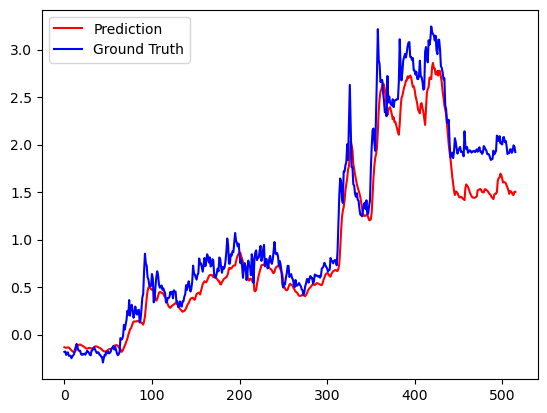

In [33]:
%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt

plt.plot(pred, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.show()